In [27]:
import numpy as np
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional

# =============================
# Lattice model (SOS approximation)
# =============================
class LatticeSOS:
    """
    Simple solid-on-solid (SOS) lattice with integer column heights.
    - heights[i, j] ∈ {0,1,2,...}
    - 4-neighbor (von Neumann) connectivity with periodic BCs.

    NOTE: This is a minimal scaffold tailored for the adaptive kMC model.
    You can replace it with your own lattice class if it exposes the same
    interface used by KMC_BKL below.
    """
    def __init__(self, size: int, seed: Optional[int] = None):
        self.size = size
        self.rng = np.random.default_rng(seed)
        self.heights = np.zeros((size, size), dtype=np.int32)

    def initialize(self, init_mode: str = "flat", max_roughness: int = 1):
        if init_mode == "flat":
            self.heights.fill(0)
        elif init_mode == "random_surface":
            self.heights = self.rng.integers(0, max(1, max_roughness+1), size=self.heights.shape, dtype=np.int32)
        else:
            raise ValueError("Unknown init_mode")

    def wrap(self, idx: int) -> int:
        n = self.size
        return (idx + n) % n

    def neighbors4(self, site: Tuple[int,int]) -> List[Tuple[int,int]]:
        i, j = site
        return [
            (self.wrap(i-1), j), (self.wrap(i+1), j),
            (i, self.wrap(j-1)), (i, self.wrap(j+1))
        ]

    def get_height(self, site: Tuple[int,int]) -> int:
        return int(self.heights[site])

    def inc_height(self, site: Tuple[int,int], dh: int = 1):
        self.heights[site] += int(dh)

    def dec_height(self, site: Tuple[int,int], dh: int = 1):
        h = int(self.heights[site])
        if h >= dh:
            self.heights[site] = h - dh

    # ---- Site classification helpers ----
    def lateral_neighbors_at_level(self, site: Tuple[int,int], level: int) -> int:
        """Count 4-neighbors whose height >= level (lateral bonding at that level)."""
        cnt = 0
        for n in self.neighbors4(site):
            if self.get_height(n) >= level:
                cnt += 1
        return cnt

    def adsorption_bonds(self, site: Tuple[int,int]) -> int:
        """
        For adsorption at site s, the new GU would attach at level = h(s)+1.
        We approximate lateral bonds as neighbors already at >= that level.
        i ∈ {0..4}. (In SOS, fully enclosed i=4 is rare; kept for completeness.)
        """
        h = self.get_height(site)
        return self.lateral_neighbors_at_level(site, h+1)

    def desorption_bonds(self, site: Tuple[int,int]) -> int:
        """
        For desorption, a GU at the top of column s (level = h(s)) is bonded
        laterally to neighbors at the same level. Approximate with neighbors having
        height >= h(s). i ∈ {0..4}. Only defined if h(s) > 0.
        """
        h = self.get_height(site)
        if h == 0:
            return 0
        return self.lateral_neighbors_at_level(site, h)

    def migration_targets(self, site: Tuple[int,int]) -> List[Tuple[int,int]]:
        """
        Available migration targets: neighbors with height <= current_height.
        (Cannot migrate to a higher step.)
        """
        h = self.get_height(site)
        if h == 0:
            return []
        targets = []
        for n in self.neighbors4(site):
            if self.get_height(n) <= h:
                targets.append(n)
        return targets

    def get_sites(self) -> List[Tuple[int,int]]:
        idxs = np.argwhere(np.ones_like(self.heights, dtype=bool))
        return [tuple(x) for x in idxs]


# =============================
# Adaptive BKL kMC (per Nagpal et al., CES 2024)
# =============================
@dataclass
class KMCParams:
    T: float                 # Temperature [K]
    S: float                 # Supersaturation S = Δμ/(k_B T)
    K0_plus: float           # K0^+ (modified attachment coefficient)
    E_pb_over_kT: float      # E_pb / (k_B T)  (avg binding energy per bond)
    phi_over_kT: float       # phi / (k_B T)   (binding energy per GU of full lattice)
    delta: float             # δ (attachment-energy parameter)


class KMC_BKL:
    """
    Rejection-free kMC (BKL) with adaptive adsorption across site classes i ∈ {0..4}.

    Rates (paper equations):
        - Adsorption (Eq. 7): r_a(i) = K0_plus * exp( S + i * (delta / S) )
          using Δμ/(k_B T) = S.
        - Desorption (Eqs. 13–16): r_d(i) = K0_plus * exp( phi_over_kT - i * E_pb_over_kT )
        - Migration  (Eq. 16):     r_m(i) = K0_plus * exp( phi_over_kT + 0.5*E_pb_over_kT - i * E_pb_over_kT )

    Event selection (Table 1): choose among adsorption/desorption/migration
    with probabilities proportional to W_a, W_d, W_m, where
        W_a = sum_i M_a(i) * r_a(i)
        W_d = sum_i M_d(i) * r_d(i)
        W_m = sum_i M_m(i) * r_m(i)   (typically i up to 3)

    Then choose class i within the chosen event as in Table 2, and finally
    choose a site uniformly within that class and execute the event.

    Time increment: Δt = -ln(ζ)/W_tot.
    """
    def __init__(self, lattice: LatticeSOS, params: KMCParams, rng_seed: Optional[int] = None):
        self.lat = lattice
        self.p = params
        self.rng = np.random.default_rng(rng_seed)
        # bookkeeping
        self.t = 0.0
        self.history = []  # list of (t, event, site)
        self.counts = {"adsorption": 0, "desorption": 0, "migration": 0}

    # ---- Rate functions per class i ----
    def r_a(self, i: int) -> float:
        S = self.p.S
        return self.p.K0_plus * np.exp(S + i * (self.p.delta / max(S, 1e-12)))

    def r_d(self, i: int) -> float:
        return self.p.K0_plus * np.exp(self.p.phi_over_kT - i * self.p.E_pb_over_kT)

    def r_m(self, i: int) -> float:
        return self.p.K0_plus * np.exp(self.p.phi_over_kT + 0.5*self.p.E_pb_over_kT - i * self.p.E_pb_over_kT)

    # ---- Build candidate classes for each event ----
    def _classify_adsorption_sites(self) -> Dict[int, List[Tuple[int,int]]]:
        bins = {0: [], 1: [], 2: [], 3: [], 4: []}
        for s in self.lat.get_sites():
            i = self.lat.adsorption_bonds(s)
            bins[min(max(i,0),4)].append(s)
        return bins

    def _classify_desorption_sites(self) -> Dict[int, List[Tuple[int,int]]]:
        bins = {0: [], 1: [], 2: [], 3: [], 4: []}
        for s in self.lat.get_sites():
            if self.lat.get_height(s) > 0:
                i = self.lat.desorption_bonds(s)
                bins[min(max(i,0),4)].append(s)
        return bins

    def _classify_migration_sites(self) -> Dict[int, List[Tuple[int,int]]]:
        """
        Sites eligible for migration are occupied sites (h>0) that have at least
        one target neighbor with height <= current (cannot migrate uphill).
        We bin them by desorption-like lateral bonds at current level (i∈{0..3}).
        """
        bins = {0: [], 1: [], 2: [], 3: []}
        for s in self.lat.get_sites():
            if self.lat.get_height(s) > 0:
                targets = self.lat.migration_targets(s)
                if not targets:
                    continue
                i = self.lat.desorption_bonds(s)
                i = min(max(i,0),3)
                bins[i].append(s)
        return bins

    # ---- Global event selection (BKL) ----
    def _choose_event_type(self, Wa: float, Wd: float, Wm: float) -> str:
        Wtot = Wa + Wd + Wm
        if Wtot <= 0.0:
            return "none"
        r = self.rng.random() * Wtot
        if r < Wa:
            return "adsorption"
        r -= Wa
        if r < Wd:
            return "desorption"
        return "migration"

    def _choose_class(self, weights: Dict[int, float]) -> int:
        total = sum(weights.values())
        r = self.rng.random() * total
        cum = 0.0
        for i in sorted(weights.keys()):
            w = weights[i]
            cum += w
            if r <= cum:
                return i
        # Fallback (shouldn't happen)
        return max(weights, key=weights.get)

    def _choose_site_uniform(self, sites: List[Tuple[int,int]]) -> Tuple[int,int]:
        idx = self.rng.integers(0, len(sites))
        return sites[idx]

    # ---- Core kMC step ----
    def step(self) -> bool:
        # Classify sites for each event type
        A_bins = self._classify_adsorption_sites()   # i ∈ {0..4}
        D_bins = self._classify_desorption_sites()   # i ∈ {0..4}
        M_bins = self._classify_migration_sites()    # i ∈ {0..3}

        # Compute Wa, Wd, Wm
        Wa = sum(len(A_bins[i]) * self.r_a(i) for i in A_bins)
        Wd = sum(len(D_bins[i]) * self.r_d(i) for i in D_bins)
        Wm = sum(len(M_bins[i]) * self.r_m(i) for i in M_bins)
        Wtot = Wa + Wd + Wm
        if Wtot <= 0.0:
            return False

        # Time increment
        z = max(self.rng.random(), 1e-12)
        dt = -np.log(z) / Wtot * 100
        self.t += dt

        # Choose event type
        etype = self._choose_event_type(Wa, Wd, Wm)
        if etype == "none":
            return False

        # Choose class i within event type (Table 2-style)
        if etype == "adsorption":
            weights = {i: (len(A_bins[i]) * self.r_a(i)) for i in A_bins if len(A_bins[i]) > 0}
            if not weights:
                return True
            i_sel = self._choose_class(weights)
            site = self._choose_site_uniform(A_bins[i_sel])
            # Execute adsorption: add one GU to the column
            self.lat.inc_height(site, 1)

        elif etype == "desorption":
            weights = {i: (len(D_bins[i]) * self.r_d(i)) for i in D_bins if len(D_bins[i]) > 0}
            if not weights:
                return True
            i_sel = self._choose_class(weights)
            site = self._choose_site_uniform(D_bins[i_sel])
            # Execute desorption: remove one GU (if any)
            self.lat.dec_height(site, 1)

        elif etype == "migration":
            weights = {i: (len(M_bins[i]) * self.r_m(i)) for i in M_bins if len(M_bins[i]) > 0}
            if not weights:
                return True
            i_sel = self._choose_class(weights)
            site = self._choose_site_uniform(M_bins[i_sel])
            # Choose a feasible target (equal or lower height), uniform
            targets = self.lat.migration_targets(site)
            if not targets:
                return True
            tgt = targets[self.rng.integers(0, len(targets))]
            # Move one GU: decrement source, increment target
            if self.lat.get_height(site) > 0 and self.lat.get_height(tgt) <= self.lat.get_height(site):
                self.lat.dec_height(site, 1)
                self.lat.inc_height(tgt, 1)

        self.counts[etype] += 1
        self.history.append((self.t, etype, site))
        return True

    def run(self, t_end: float, snapshot_times: Optional[List[float]] = None):
        """Run until simulated time reaches t_end. Return snapshots (time, heights copy)."""
        snapshots: List[Tuple[float, np.ndarray]] = []
        next_snap_idx = 0
        if snapshot_times is None:
            snapshot_times = []
        snapshot_times = sorted(snapshot_times)

        while self.t < t_end:
            print(self.t)
            progressed = self.step()
            if not progressed:
                break
            # capture snapshots
            while next_snap_idx < len(snapshot_times) and self.t >= snapshot_times[next_snap_idx]:
                snapshots.append((snapshot_times[next_snap_idx], self.lat.heights.copy()))
                next_snap_idx += 1
        # final snapshot at t_end if requested beyond last time
        if snapshot_times and (next_snap_idx < len(snapshot_times)):
            # fill the rest with final state
            while next_snap_idx < len(snapshot_times):
                snapshots.append((snapshot_times[next_snap_idx], self.lat.heights.copy()))
                next_snap_idx += 1
        return snapshots

0.0
0.003607413596471432
0.01999697433279603
0.03210949034854199
0.04535577285755571
0.048170493395779314
0.050278950771850156
0.06715688384225424
0.10665240436667467
0.10744893683143325
0.121722638754249
0.13371882984992317
0.13971397851035405
0.1531444111486521
0.19273012900098782
0.1998152354326543
0.20881902257809906
0.21049949171962243
0.21696820158398142
0.2246671882163752
0.229061909597294
0.23577753717788344
0.260437866728339
0.2631847664593192
0.26577573138131516
0.27681114120730665
0.2778108645356255
0.2798913041939838
0.287825405803358
0.30373150662321846
0.3051406047718897
0.30925509947611796
0.3268221816042254
0.339840581910128
0.3443559113864779
0.35559905175195683
0.35903930184952615
0.36614400702316946
0.37244569399040395
0.3864242143276637
0.3865945685128972
0.3873862998545583
0.4031463733017794
0.4102457832596167
0.41987810289121963
0.4237904826825494
0.4245257596968524
0.42549184401754625
0.4280034604271876
0.4410349118041089
0.4481565544667523
0.4552485811195938
0.4

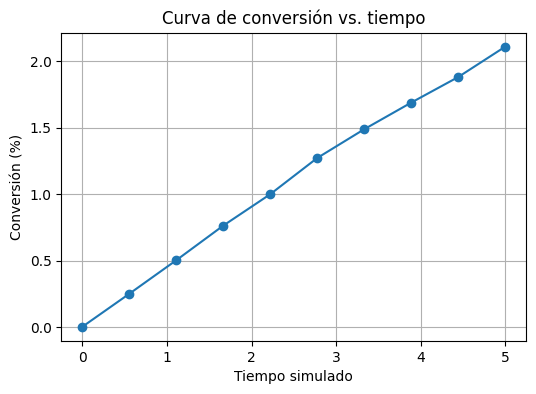

In [29]:
import matplotlib.pyplot as plt

def plot_conversion_curve(snaps, times, N_bulk):
    """
    Graficar la curva de conversión (%) vs tiempo.
    
    snaps: lista de (t, heights) devuelta por kmc.run()
    times: lista de tiempos en que se pidieron snapshots
    N_bulk: número total de GUs disponibles (referencia para 100%)
    """
    # Número de GUs ocupadas en cada snapshot
    occupied = [np.sum(h) for _, h in snaps]
    
    # Conversión en %
    conversion = [occ / N_bulk * 100 for occ in occupied]

    # Gráfica
    plt.figure(figsize=(6,4))
    plt.plot(times, conversion, marker="o")
    plt.xlabel("Tiempo simulado")
    plt.ylabel("Conversión (%)")
    plt.title("Curva de conversión vs. tiempo")
    plt.grid(True)
    plt.show()
    return conversion

# ======================
# Ejemplo de uso
# ======================

L = LatticeSOS(size=50, seed=42)
L.initialize(init_mode="flat")

params = KMCParams(
    T=298.15,
    S=3,
    K0_plus=0.211,
    E_pb_over_kT=0.1,
    phi_over_kT=2.76,
    delta=0.2
)

kmc = KMC_BKL(lattice=L, params=params, rng_seed=123)

times = np.linspace(0.0, 5.0, 10)
snaps = kmc.run(t_end=5.0, snapshot_times=times)

# Supongamos que tenías N_bulk = 50*50*10 GUs disponibles (ejemplo)
N_bulk = 50 * 50 * 10
conversion = plot_conversion_curve(snaps, times, N_bulk)
